In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  786M    1 10.4M    0     0  9369k      0  0:01:25  0:00:01  0:01:24 9380k
  3  786M    3 27.0M    0     0  12.6M      0  0:01:02  0:00:02  0:01:00 12.6M
  5  786M    5 44.7M    0     0  14.2M      0  0:00:55  0:00:03  0:00:52 14.2M
  7  786M    7 62.8M    0     0  15.1M      0  0:00:51  0:00:04  0:00:47 15.1M
 10  786M   10 80.0M    0     0  15.4M      0  0:00:51  0:00:05  0:00:46 15.9M
 12  786M   12 96.0M    0     0  15.6M      0  0:00:50  0:00:06  0:00:44 17.1M
 14  786M   14  116M    0     0  16.3M      0  0:00:48  0:00:07  0:00:41 17.9M
 17  786M   17  136M    0     0  16.7M      0  0:00:46  0:00:08  0:00:38 18.3M
 19  786M   19  151M    0     0  16.5M      0  0:00

In [3]:
import zipfile

with zipfile.ZipFile('kagglecatsanddogs_5340.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    max_images = 100
    folder_path = os.path.join("PetImages", folder_name)
    for image_i,fname in enumerate(os.listdir(folder_path)):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if image_i > max_images or not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 24810 images.


In [5]:
image_size = (224, 224)

batch_size = 10

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 192 files belonging to 2 classes.
Using 154 files for training.


Using 38 files for validation.


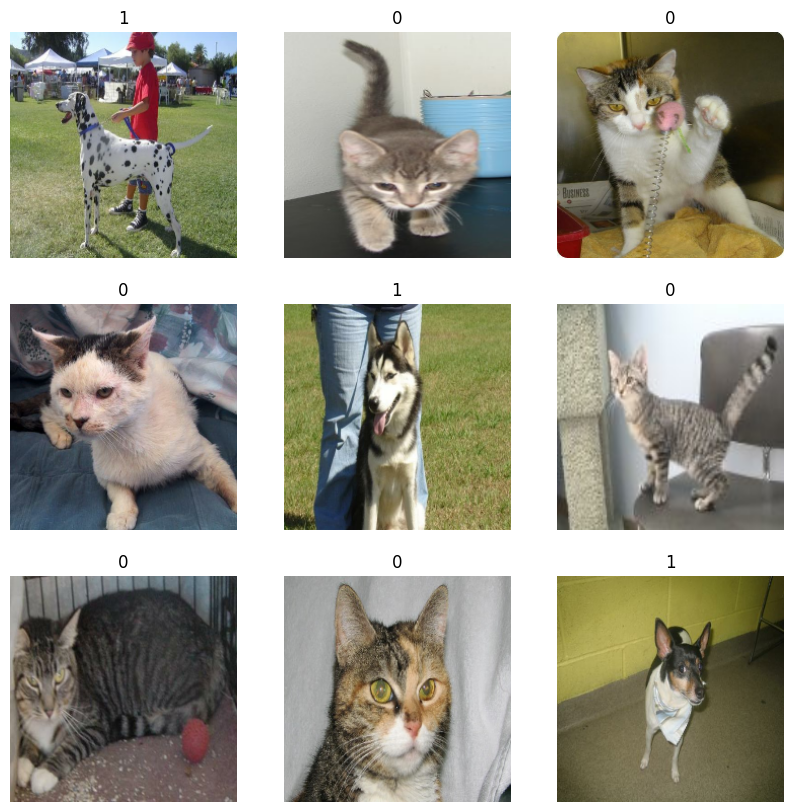

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

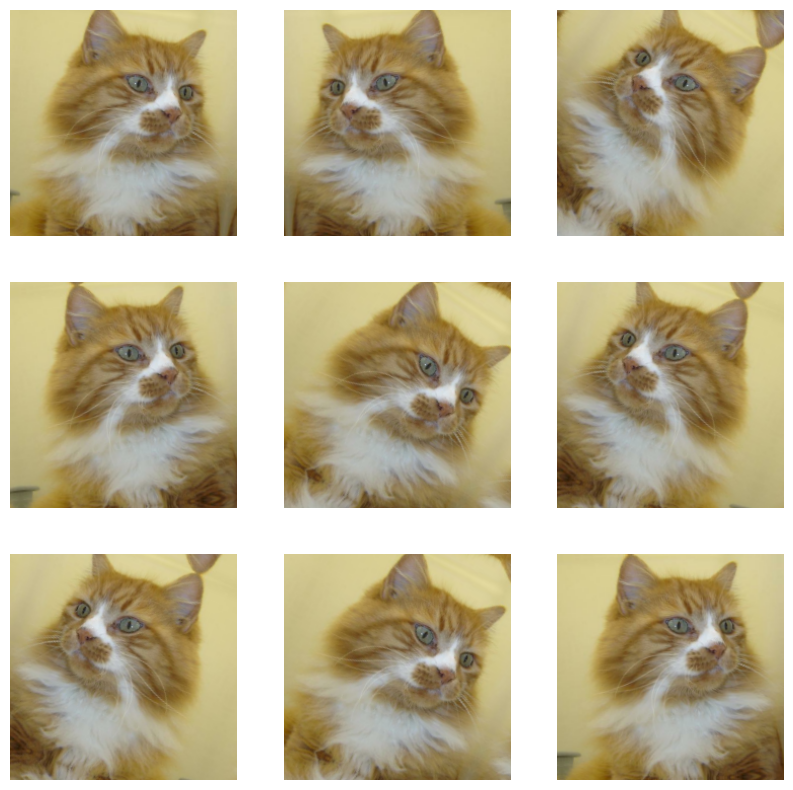

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [9]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

In [11]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - acc: 0.6107 - loss: 0.7427 - val_acc: 0.5000 - val_loss: 0.6934
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - acc: 0.7267 - loss: 0.6156 - val_acc: 0.5000 - val_loss: 0.6939
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - acc: 0.6970 - loss: 0.5939 - val_acc: 0.5000 - val_loss: 0.6946
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - acc: 0.7311 - loss: 0.5392 - val_acc: 0.5000 - val_loss: 0.6952
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - acc: 0.6463 - loss: 0.6480 - val_acc: 0.5000 - val_loss: 0.6963
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - acc: 0.7008 - loss: 0.4837 - val_acc: 0.5000 - val_loss: 0.6976
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - acc: 0.7656 - loss: 0.4727 - val_acc: 0.5000 - val_loss: 0.6993
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - acc: 0.7878 - loss: 0.4954 - val_acc: 0.5000 - val_loss: 0.7008
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - acc: 0.7555 - loss: 

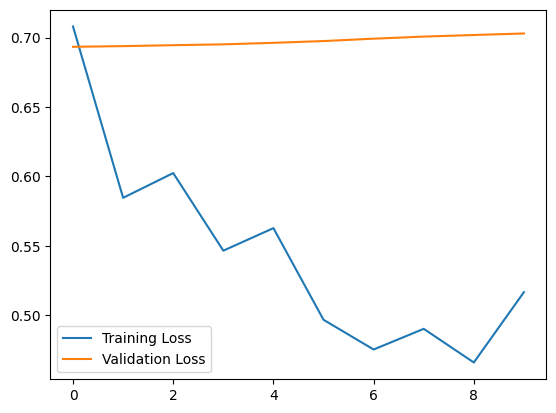

In [12]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

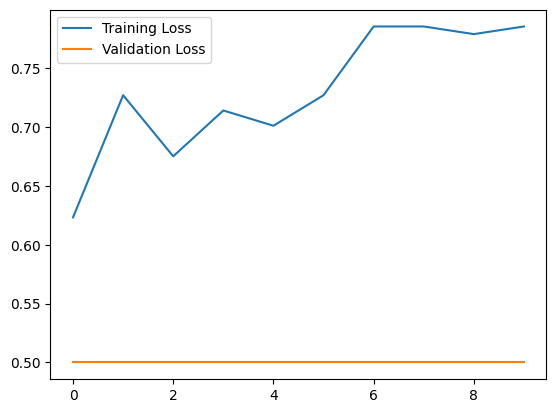

In [13]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()